# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [1]:
#No Google Colab será necessário executar as instalações abaixo a cada nova sessão.
#No Jupyter Notebook, Jupyter Lab ou VSCode (localhost) basta instalar uma única vez.
# !pip uninstall pycaret
!pip install pandas
!pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [3]:
import pandas as pd
import os

# Caminho do arquivo
file_path = '/content/all_movies.csv'

# Verificar se o arquivo existe
if not os.path.exists(file_path):
    print(f"Erro: O arquivo não existe no caminho {file_path}")
    print("Conteúdo do diretório /content:")
    print(os.listdir('/content'))
else:
    # Tentar ler o arquivo
    try:
        # Tentar ler as primeiras linhas do arquivo para diagnóstico
        with open(file_path, 'r', encoding='utf-8') as f:
            print("Primeiras 5 linhas do arquivo:")
            for i, line in enumerate(f):
                if i < 5:
                    print(line.strip())
                else:
                    break

        # Tentar ler o arquivo com pandas
        df = pd.read_csv(file_path)
        print("\nArquivo lido com sucesso!")
        print(f"Número de linhas: {len(df)}")
        print(f"Número de colunas: {len(df.columns)}")
        print("\nPrimeiras 5 linhas do DataFrame:")
        print(df.head())

    except pd.errors.EmptyDataError:
        print("Erro: O arquivo está vazio.")
    except pd.errors.ParserError as e:
        print(f"Erro ao analisar o arquivo CSV: {str(e)}")
        print("Isso pode indicar um problema com o formato do arquivo.")
    except UnicodeDecodeError:
        print("Erro de decodificação Unicode. Tentando com encoding='latin-1'...")
        df = pd.read_csv(file_path, encoding='latin-1')
        print("Arquivo lido com sucesso usando encoding='latin-1'")
        print(df.head())
    except Exception as e:
        print(f"Ocorreu um erro ao ler o arquivo: {str(e)}")
        print(f"Tipo do erro: {type(e).__name__}")

Primeiras 5 linhas do arquivo:
title_pt;title_en;year;rating;genre;sinopse
Barbie;Barbie;2023;7.4;Aventura;Viver na Terra da Barbie é ser um ser perfeito em um lugar perfeito. A menos que você tenha uma crise existencial completa. Ou que você seja um Ken.
Um Sonho de Liberdade;1. The Shawshank Redemption;1994;9.3;Drama;Dois homens presos se reúnem ao longo de vários anos, encontrando consolo e eventual redenção através de atos de decência comum.
O Poderoso Chefão;2. The Godfather;1972;9.2;Policial;O patriarca idoso de uma dinastia do crime organizado transfere o controle de seu império clandestino para seu filho relutante.
Batman: O Cavaleiro das Trevas;3. The Dark Knight;2008;9.0;Ação;Quando a ameaça conhecida como O Coringa surge de seu passado, causa estragos e caos nas pessoas de Gotham. O Cavaleiro das Trevas deve aceitar um dos maiores testes para combater a injustiça.
Erro ao analisar o arquivo CSV: Error tokenizing data. C error: Expected 1 fields in line 3, saw 2

Isso pode in

#EDA - Exploratory Data Analysis

In [4]:
import pandas as pd
import os

# Caminho do arquivo
file_path = '/content/all_movies.csv'

# Verificar se o arquivo existe
if os.path.exists(file_path):
    try:
        # Tentar ler o arquivo CSV
        df = pd.read_csv(file_path, sep=';')
        print("Arquivo lido com sucesso!")

        # Exibir informações básicas
        print(f"\nShape do DataFrame: {df.shape}")

        print("\nPrimeiras 5 linhas do DataFrame:")
        print(df.head())

        print("\nInformações do DataFrame:")
        print(df.info())

        print("\nNomes das colunas:")
        print(df.columns.tolist())

        print("\nResumo estatístico das colunas numéricas:")
        print(df.describe())

    except pd.errors.EmptyDataError:
        print("Erro: O arquivo está vazio.")
    except pd.errors.ParserError as e:
        print(f"Erro ao analisar o arquivo CSV: {str(e)}")
        print("Isso pode indicar um problema com o formato do arquivo ou o separador usado.")
    except Exception as e:
        print(f"Ocorreu um erro ao ler o arquivo: {str(e)}")
else:
    print(f"Erro: O arquivo não foi encontrado no caminho {file_path}")
    print("Conteúdo do diretório /content:")
    print(os.listdir('/content'))

Arquivo lido com sucesso!

Shape do DataFrame: (250, 6)

Primeiras 5 linhas do DataFrame:
                         title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  
0  Aventura  Viver na Terra da Barbie é ser um ser perfeito...  
1     Drama  Dois homens presos se reúnem ao longo de vário...  
2  Policial  O patriarca idoso de uma dinastia do crime org...  
3      Ação  Quando a ameaça conhecida como O Coringa surge...  
4  Policial  Em 1950, Michael Corleone, agora à frente da f...  

Informações do DataFrame:
<class 'pand

In [5]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  250 non-null    object 
 1   title_en  250 non-null    object 
 2   year      250 non-null    int64  
 3   rating    250 non-null    float64
 4   genre     250 non-null    object 
 5   sinopse   250 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ KB


In [7]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000

## Plots

In [8]:
df.genre.value_counts('d')

genre
Drama         0.276
Ação          0.180
Policial      0.140
Animação      0.096
Biografia     0.092
Comédia       0.092
Aventura      0.084
Terror        0.016
Mistério      0.016
Faroeste      0.004
Filme noir    0.004
Name: proportion, dtype: float64

In [9]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

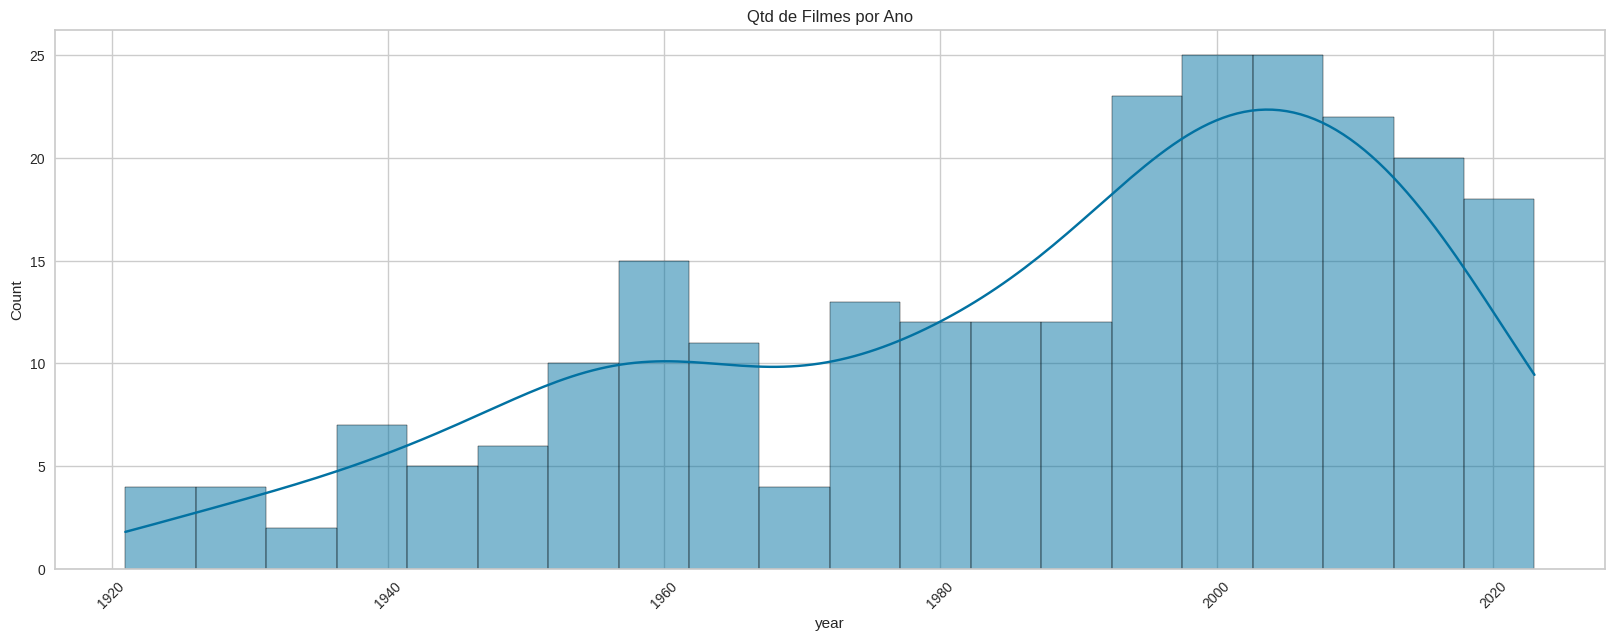

In [10]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

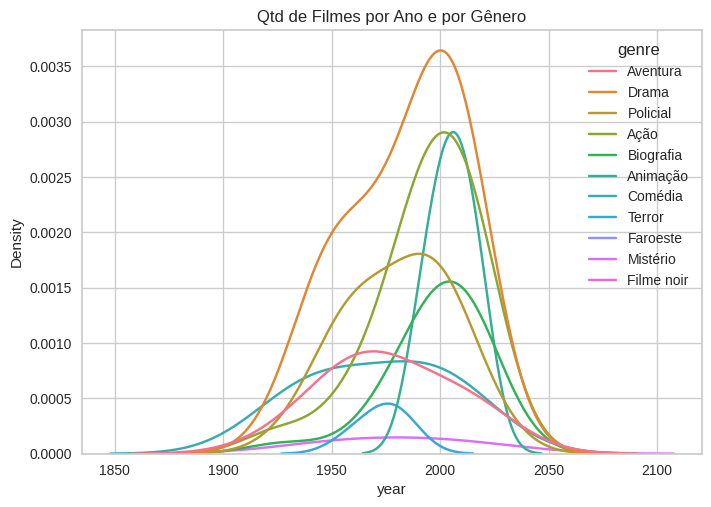

In [11]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [12]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    viver na terra da barbie é ser um ser perfeito...
1    dois homens presos se reúnem ao longo de vário...
2    o patriarca idoso de uma dinastia do crime org...
3    quando a ameaça conhecida como o coringa surge...
4    em 1950, michael corleone, agora à frente da f...
Name: sinopse, dtype: object

In [13]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [14]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  word_count  
0  Aventura  viver na terra da barbie é ser um ser perfeito...          29  
1     Drama  dois homens presos se reúnem ao longo de vário...          21  
2  Policial  o patriarca idoso de uma dinastia do crime org...          20  
3      Ação  quando a ameaça conhecida como o coringa surge...          33  
4  Policial  em 1950, michael corleone, agora à frente da f...          41

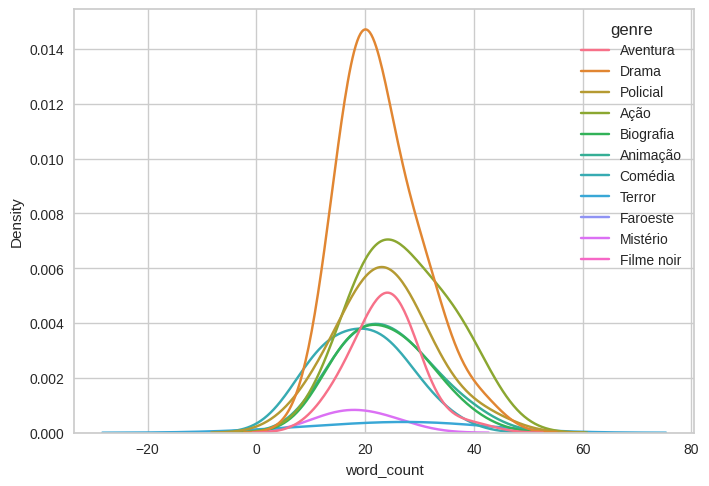

In [15]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

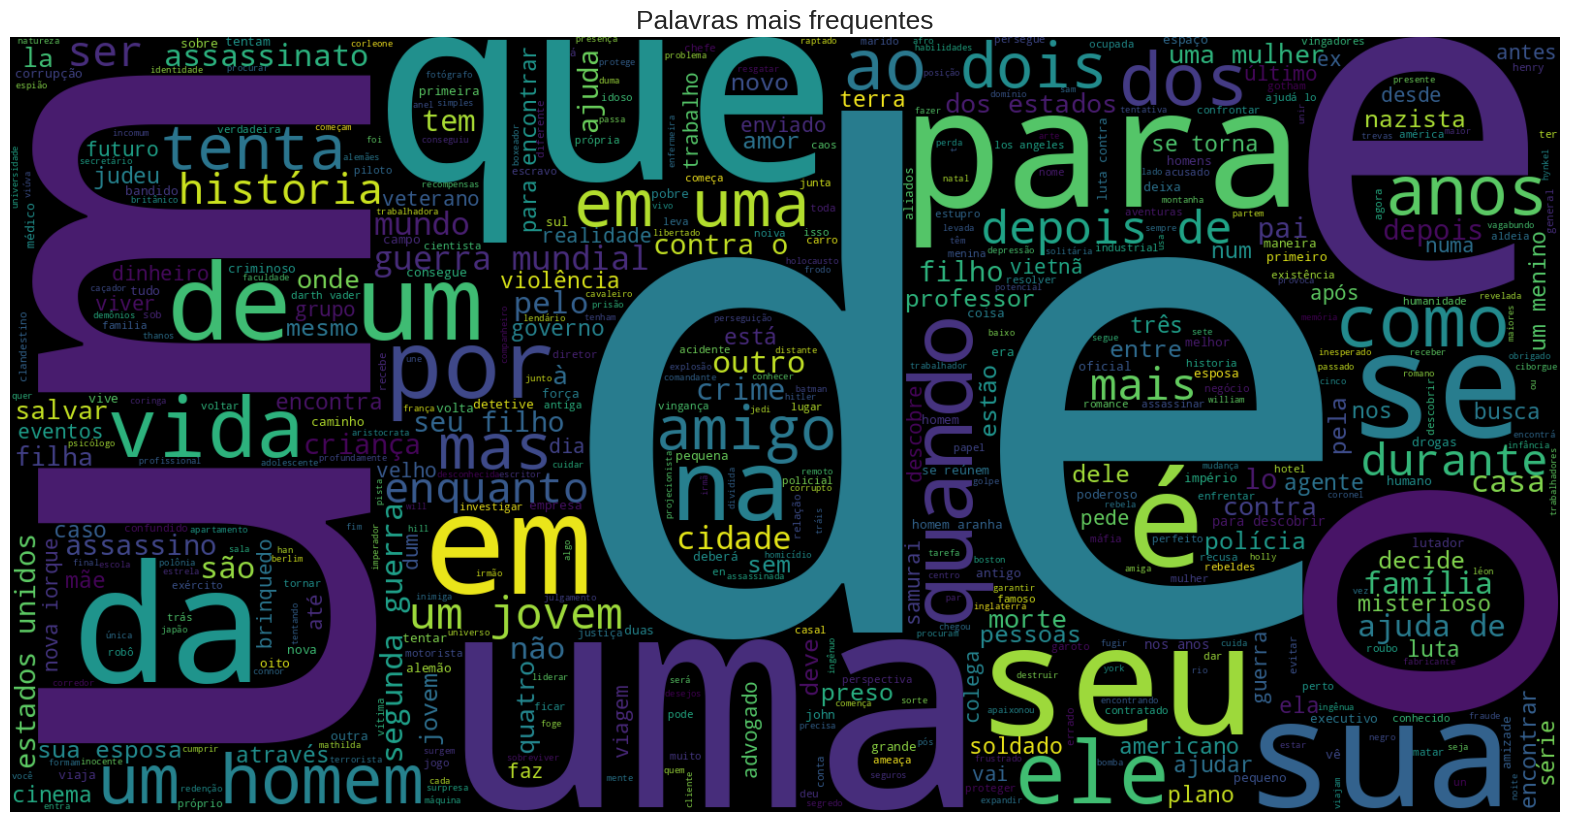

In [16]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [17]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


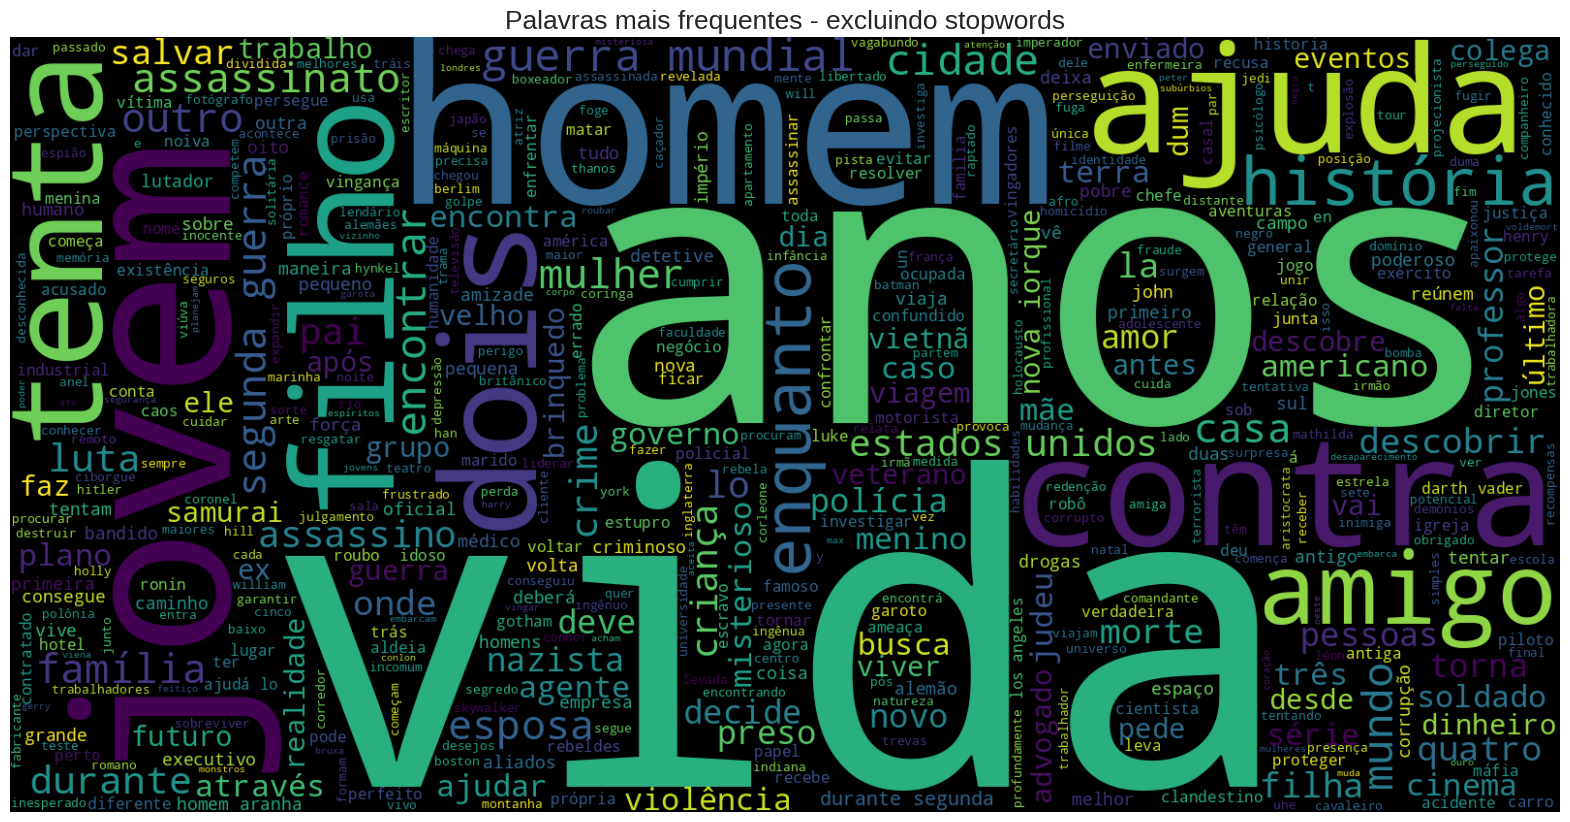

In [18]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [19]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [20]:
print(X.shape)
X.toarray()

(250, 82)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

# Model 1

## Setup

In [21]:
s = setup(data = X.toarray(),
          session_id = 123)

## Create Model

In [22]:
mdl_kmeans = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
mdl_dbscan = create_model('dbscan')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Assign Model

In [24]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster
Cluster 2    219
Cluster 1     19
Cluster 0      6
Cluster 3      6
Name: count, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        0.0   
4          0.0        0.0        0.0        0.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
245        0.0        0.0        0.0        0.0        0.0        0.0   
246        0.0        0.0        0.0        0.0        0.0        0.0   
247        0.0        0.0        0.0        0.0        0.0        0.0   
248        0.0        0.0        0.0        0.0        0.0        0.0   
249        0.0        0.0        0.0        0.0        0.0        0.0   

     feature_7  feature_8  feature_9  feature_10  ...  feature_74  feature_75  \
0     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
1     0.499298        0.0        0.0         0.0  ...         0.0         0.0   
2     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
3     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
4     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
..         ...        ...        ...         ...  ...         ...         ...   
245   0.376643        0.0        0.0         0.0  ...         0.0         0.0   
246   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
247   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
248   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
249   0.000000        0.0        0.0         0.0  ...         0.0         0.0   

     feature_76  feature_77  feature_78  feature_79  feature_80  feature_81  \
0           0.0    0.000000         0.0         0.0         0.0         0.0   
1           0.0    0.000000         0.0         0.0         0.0         0.0   
2           0.0    0.000000         0.0         0.0         0.0         0.0   
3           0.0    0.000000         0.0         0.0         0.0         0.0   
4           0.0    0.000000         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
245         0.0    0.469184         0.0         0.0         0.0         0.0   
246         0.0    0.000000         0.0         0.0         0.0         0.0   
247         0.0    0.000000         0.0         1.0         0.0         0.0   
248         0.0    0.000000         0.0         0.0         0.0         0.0   
249         0.0    0.000000         0.0         0.0         0.0         0.0   

     feature_82    Cluster  
0      0.707107  Cluster 2  
1      0.000000  Cluster 2  
2      0.000000  Cluster 2  
3      0.000000  Cluster 2  
4      0.000000  Cluster 2  
..          ...        ...  
245    0.000000  Cluster 2  
246    0.000000  Cluster 2  
247    0.000000  Cluster 2  
248    0.000000  Cluster 2  
249    0.000000  Cluster 2  

[250 rows x 83 columns]

In [25]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster
Cluster -1    241
Cluster 0       9
Name: count, dtype: int64

## Analyze Models

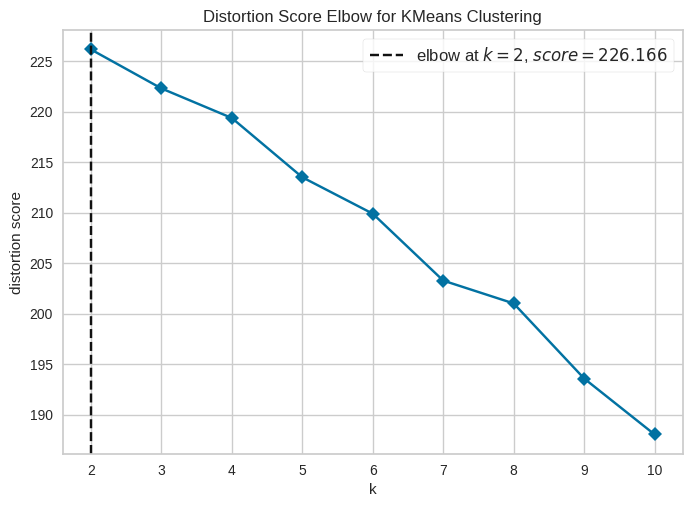

In [26]:
plot_model(mdl_kmeans, plot = 'elbow')

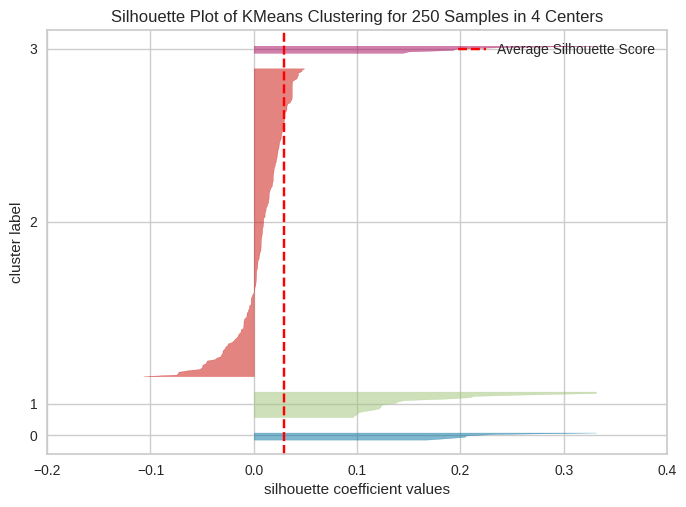

In [27]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [28]:
plot_model(mdl_kmeans, plot = 'distribution')

In [29]:
plot_model(mdl_kmeans, plot = 'cluster')

In [30]:
plot_model(mdl_kmeans, plot = 'tsne')

In [31]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Filmes por cluster

In [32]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    cluster  
0            29  viver terra barbie perfeito lugar perfeito. me...  Cluster 2  
1            21  dois homens presos reúnem longo vários anos, e...  Cluster 2  
2            20  patriarca idoso dinastia crime organizado tran...  Cluster 2  
3            33  ameaça conhecida coringa surge passado, causa ...  Cluster 2  
4            41  1950, michael corleone, agora frente família, ...  Cluster 2  
..          ...                                                ...        ...  
245          32  aspirante escritora durante movimento direitos...  Cluster 2  
246          17  enfermeira encarregada atriz silenciosa descob...  Cluster 2  
247          20  nascido natal original estábulo lado jesus, br...  Cluster 2  
248          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 2  
249          22  esposa amante diretor escola detestável planej...  Cluster 2  

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [33]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

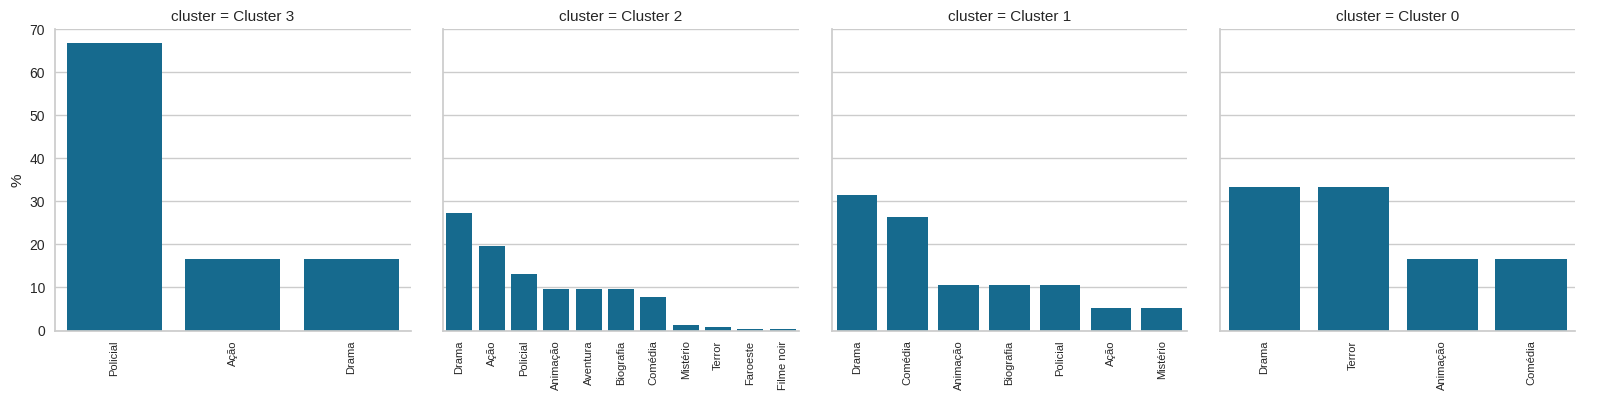

In [34]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

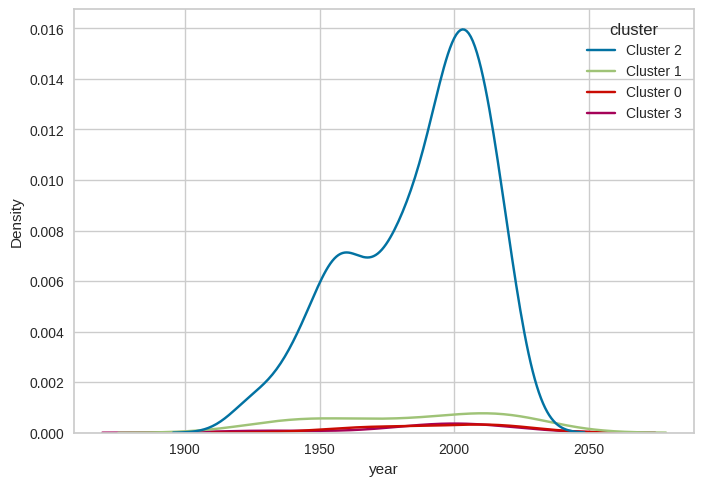

In [35]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [36]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação  16.666667  10.526316   9.589041   0.000000
1          Aventura   0.000000   0.000000   9.589041   0.000000
2              Ação   0.000000   5.263158  19.634703  16.666667
3         Biografia   0.000000  10.526316   9.589041   0.000000
4           Comédia  16.666667  26.315789   7.762557   0.000000
5             Drama  33.333333  31.578947  27.397260  16.666667
6          Faroeste   0.000000   0.000000   0.456621   0.000000
7        Filme noir   0.000000   0.000000   0.456621   0.000000
8          Mistério   0.000000   5.263158   1.369863   0.000000
9          Policial   0.000000  10.526316  13.242009  66.666667
10           Terror  33.333333   0.000000   0.913242   0.000000

In [37]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0  16.666667
1   Aventura  Cluster 0   0.000000
2       Ação  Cluster 0   0.000000
3  Biografia  Cluster 0   0.000000
4    Comédia  Cluster 0  16.666667

In [38]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 2


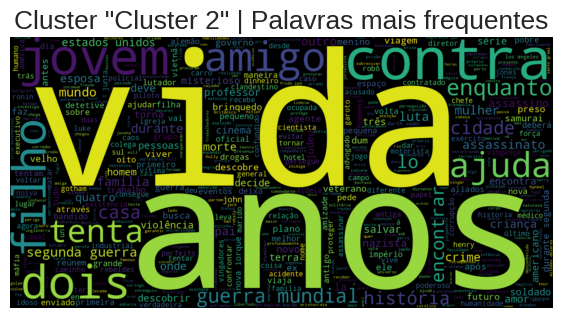

Cluster 1


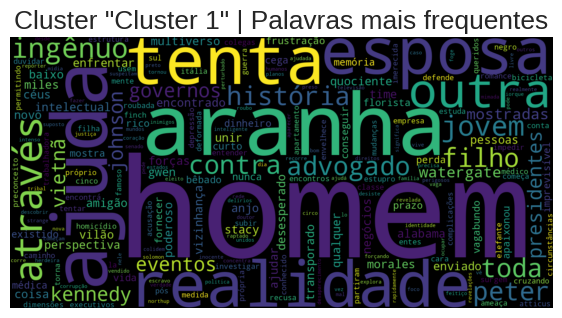

Cluster 0


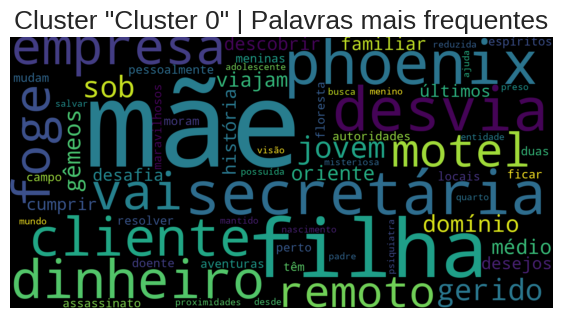

Cluster 3


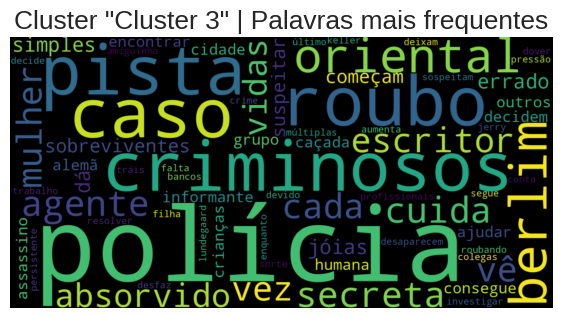

In [39]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 1

In [40]:
#Escreva aqui as suas análises / conclusões

# Model 2

## Adicionando demais features do df all_movies ao X

In [41]:
pd.DataFrame(X.toarray()).shape

(250, 82)

In [42]:
df_processed.shape

(250, 9)

In [43]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    0    1  \
0            29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0   
1            21  dois homens presos reúnem longo vários anos, e...  0.0  0.0   
2            20  patriarca idoso dinastia crime organizado tran...  0.0  0.0   
3            33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0   
4            41  1950, michael corleone, agora frente família, ...  0.0  0.0   
..          ...                                                ...  ...  ...   
245          32  aspirante escritora durante movimento direitos...  0.0  0.0   
246          17  enfermeira encarregada atriz silenciosa descob...  0.0  0.0   
247          20  nascido natal original estábulo lado jesus, br...  0.0  0.0   
248          23  menino rua bondoso vizir competem lâmpada mági...  0.0  0.0   
249          22  esposa amante diretor escola detestável planej...  0.0  0.0   

     ...        72   73   74   75        76   77   78   79   80        81  
0    ...  0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  
1    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
2    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
3    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
4    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
..   ...       ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  
245  ...  0.000000  0.0  0.0  0.0  0.469184  0.0  0.0  0.0  0.0  0.000000  
246  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
247  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  
248  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
249  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  

[250 rows x 90 columns]

## Setup

In [44]:
s = setup(data = df_all,
          session_id = 123)

## Create Model

In [45]:
mdl_kmeans_all = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Assign Model

In [46]:
df_kmeans_all = assign_model(mdl_kmeans_all)
display(df_kmeans_all.Cluster.value_counts())
df_kmeans_all

Cluster
Cluster 3    79
Cluster 1    66
Cluster 0    57
Cluster 2    48
Name: count, dtype: int64

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    0    1  \
0            29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0   
1            21  dois homens presos reúnem longo vários anos, e...  0.0  0.0   
2            20  patriarca idoso dinastia crime organizado tran...  0.0  0.0   
3            33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0   
4            41  1950, michael corleone, agora frente família, ...  0.0  0.0   
..          ...                                                ...  ...  ...   
245          32  aspirante escritora durante movimento direitos...  0.0  0.0   
246          17  enfermeira encarregada atriz silenciosa descob...  0.0  0.0   
247          20  nascido natal original estábulo lado jesus, br...  0.0  0.0   
248          23  menino rua bondoso vizir competem lâmpada mági...  0.0  0.0   
249          22  esposa amante diretor escola detestável planej...  0.0  0.0   

     ...   73   74   75        76   77   78   79   80        81    Cluster  
0    ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  Cluster 2  
1    ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3  
2    ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 0  
3    ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 2  
4    ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 0  
..   ...  ...  ...  ...       ...  ...  ...  ...  ...       ...        ...  
245  ...  0.0  0.0  0.0  0.469184  0.0  0.0  0.0  0.0  0.000000  Cluster 2  
246  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 1  
247  ...  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  Cluster 0  
248  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 0  
249  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 1  

[250 rows x 91 columns]

## Analyze Model

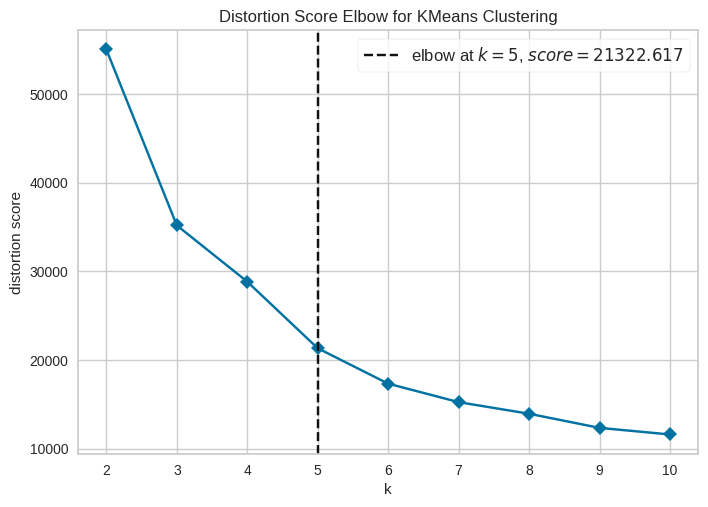

In [47]:
plot_model(mdl_kmeans_all, plot = 'elbow')

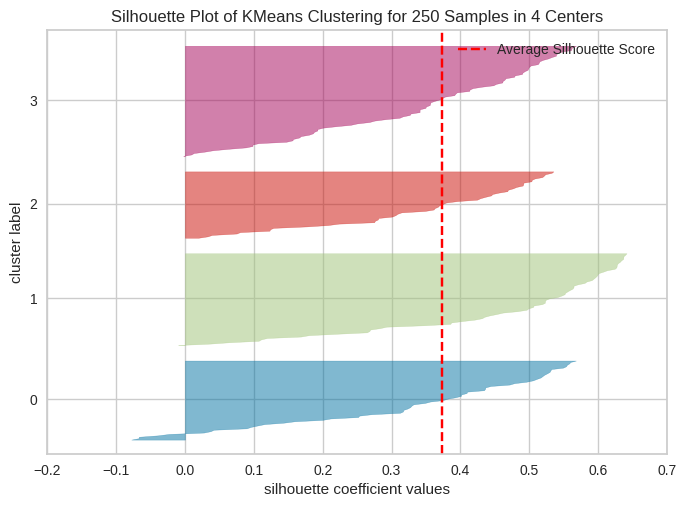

In [48]:
plot_model(mdl_kmeans_all, plot = 'silhouette')

In [49]:
plot_model(mdl_kmeans_all, plot = 'distribution')

In [50]:
plot_model(mdl_kmeans_all, plot = 'cluster')

In [51]:
plot_model(mdl_kmeans_all, plot = 'tsne')

In [52]:
evaluate_model(mdl_kmeans_all)

## Filmes por cluster

In [53]:
df_processed['cluster'] = df_kmeans_all['Cluster']
df_processed

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    cluster  
0            29  viver terra barbie perfeito lugar perfeito. me...  Cluster 2  
1            21  dois homens presos reúnem longo vários anos, e...  Cluster 3  
2            20  patriarca idoso dinastia crime organizado tran...  Cluster 0  
3            33  ameaça conhecida coringa surge passado, causa ...  Cluster 2  
4            41  1950, michael corleone, agora frente família, ...  Cluster 0  
..          ...                                                ...        ...  
245          32  aspirante escritora durante movimento direitos...  Cluster 2  
246          17  enfermeira encarregada atriz silenciosa descob...  Cluster 1  
247          20  nascido natal original estábulo lado jesus, br...  Cluster 0  
248          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 0  
249          22  esposa amante diretor escola detestável planej...  Cluster 1  

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [54]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

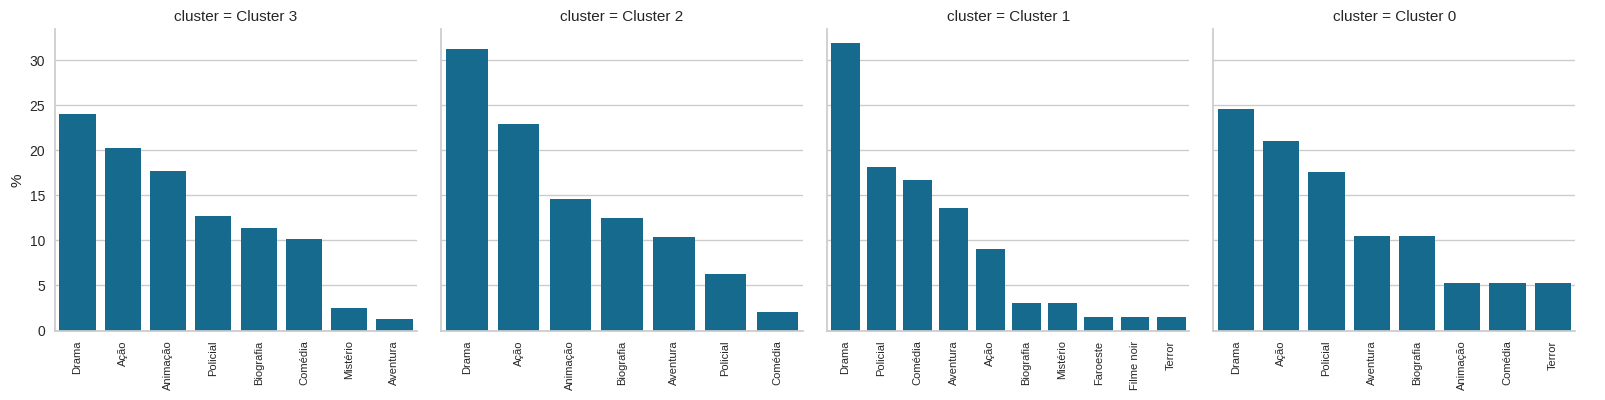

In [55]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

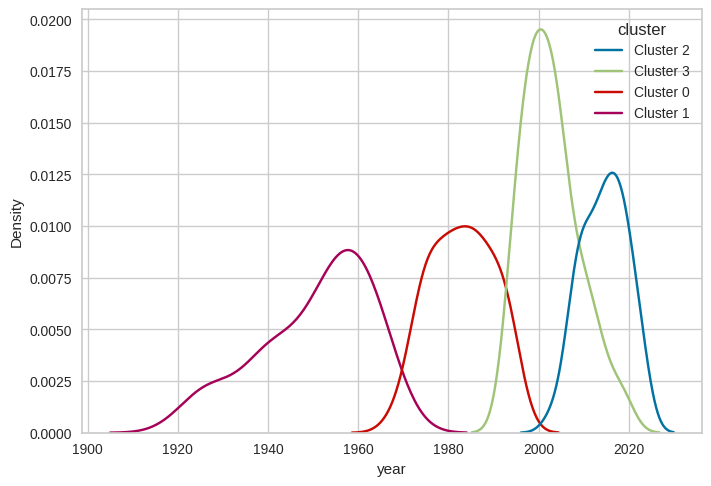

In [56]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [57]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação   5.263158   0.000000  14.583333  17.721519
1          Aventura  10.526316  13.636364  10.416667   1.265823
2              Ação  21.052632   9.090909  22.916667  20.253165
3         Biografia  10.526316   3.030303  12.500000  11.392405
4           Comédia   5.263158  16.666667   2.083333  10.126582
5             Drama  24.561404  31.818182  31.250000  24.050633
6          Faroeste   0.000000   1.515152   0.000000   0.000000
7        Filme noir   0.000000   1.515152   0.000000   0.000000
8          Mistério   0.000000   3.030303   0.000000   2.531646
9          Policial  17.543860  18.181818   6.250000  12.658228
10           Terror   5.263158   1.515152   0.000000   0.000000

In [58]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   5.263158
1   Aventura  Cluster 0  10.526316
2       Ação  Cluster 0  21.052632
3  Biografia  Cluster 0  10.526316
4    Comédia  Cluster 0   5.263158

In [59]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 2


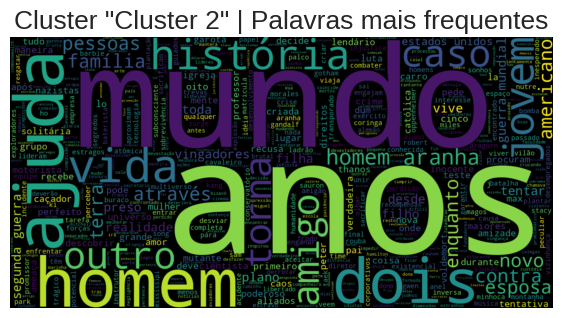

Cluster 3


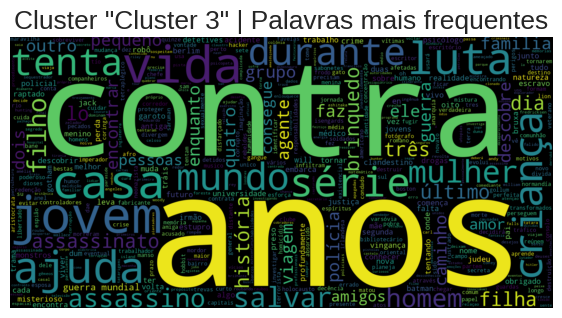

Cluster 0


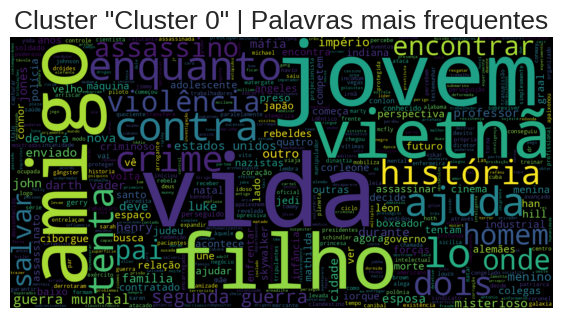

Cluster 1


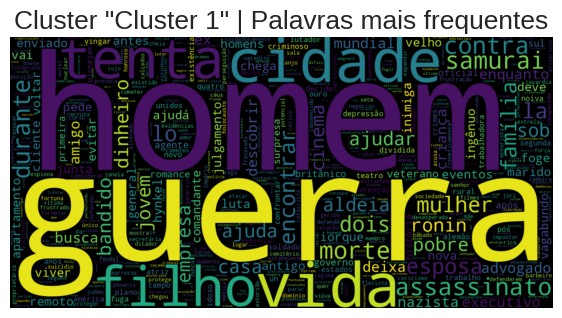

In [60]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 2

In [61]:
#Escreva aqui as suas análises / conclusões

# Model #3

## Excluindo a feature "year" dado que o modelo claramente separou os clusters com forte influência do ano de lançamento dos filmes

In [62]:
pd.DataFrame(X.toarray()).shape

(250, 82)

In [63]:
df_processed.shape

(250, 9)

In [64]:
df_all_no_year = pd.concat([
                    df_processed.drop(['cluster','year'], axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all_no_year

title_pt                     title_en  rating  \
0                            Barbie                       Barbie     7.4   
1             Um Sonho de Liberdade  1. The Shawshank Redemption     9.3   
2                 O Poderoso Chefão             2. The Godfather     9.2   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight     9.0   
4              O Poderoso Chefão II     4. The Godfather Part II     9.0   
..                              ...                          ...     ...   
245              Histórias Cruzadas                246. The Help     8.1   
246      Quando Duas Mulheres Pecam                 247. Persona     8.1   
247                 A Vida de Brian           248. Life of Brian     8.0   
248                         Aladdin                 249. Aladdin     8.0   
249                   As Diabólicas              250. Diabolique     8.1   

        genre                                            sinopse  word_count  \
0    Aventura  viver na terra da barbie é ser um ser perfeito...          29   
1       Drama  dois homens presos se reúnem ao longo de vário...          21   
2    Policial  o patriarca idoso de uma dinastia do crime org...          20   
3        Ação  quando a ameaça conhecida como o coringa surge...          33   
4    Policial  em 1950, michael corleone, agora à frente da f...          41   
..        ...                                                ...         ...   
245     Drama  uma aspirante a escritora durante o movimento ...          32   
246     Drama  uma enfermeira é encarregada de uma atriz sile...          17   
247   Comédia  nascido no natal original no estábulo ao lado ...          20   
248  Animação  um menino de rua bondoso e um vizir competem p...          23   
249  Policial  a esposa e a amante de um diretor de escola de...          22   

                                  sinopse_no_stopwords    0    1    2  ...  \
0    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  ...   
1    dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  ...   
2    patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  ...   
3    ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  ...   
4    1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  ...   
..                                                 ...  ...  ...  ...  ...   
245  aspirante escritora durante movimento direitos...  0.0  0.0  0.0  ...   
246  enfermeira encarregada atriz silenciosa descob...  0.0  0.0  0.0  ...   
247  nascido natal original estábulo lado jesus, br...  0.0  0.0  0.0  ...   
248  menino rua bondoso vizir competem lâmpada mági...  0.0  0.0  0.0  ...   
249  esposa amante diretor escola detestável planej...  0.0  0.0  0.0  ...   

           72   73   74   75        76   77   78   79   80        81  
0    0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  
1    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
2    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
3    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
4    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
..        ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  
245  0.000000  0.0  0.0  0.0  0.469184  0.0  0.0  0.0  0.0  0.000000  
246  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
247  0.000000  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  
248  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
249  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  

[250 rows x 89 columns]

## Setup

In [65]:
s = setup(data = df_all_no_year,
          session_id = 123)

## Create Model

In [66]:
mdl_kmeans_all_no_year = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Assign Model

In [67]:
df_kmeans_all_no_year = assign_model(mdl_kmeans_all_no_year)
display(df_kmeans_all_no_year.Cluster.value_counts())
df_kmeans_all_no_year

Cluster
Cluster 3    86
Cluster 1    66
Cluster 0    59
Cluster 2    39
Name: count, dtype: int64

title_pt                     title_en  rating  \
0                            Barbie                       Barbie     7.4   
1             Um Sonho de Liberdade  1. The Shawshank Redemption     9.3   
2                 O Poderoso Chefão             2. The Godfather     9.2   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight     9.0   
4              O Poderoso Chefão II     4. The Godfather Part II     9.0   
..                              ...                          ...     ...   
245              Histórias Cruzadas                246. The Help     8.1   
246      Quando Duas Mulheres Pecam                 247. Persona     8.1   
247                 A Vida de Brian           248. Life of Brian     8.0   
248                         Aladdin                 249. Aladdin     8.0   
249                   As Diabólicas              250. Diabolique     8.1   

        genre                                            sinopse  word_count  \
0    Aventura  viver na terra da barbie é ser um ser perfeito...          29   
1       Drama  dois homens presos se reúnem ao longo de vário...          21   
2    Policial  o patriarca idoso de uma dinastia do crime org...          20   
3        Ação  quando a ameaça conhecida como o coringa surge...          33   
4    Policial  em 1950, michael corleone, agora à frente da f...          41   
..        ...                                                ...         ...   
245     Drama  uma aspirante a escritora durante o movimento ...          32   
246     Drama  uma enfermeira é encarregada de uma atriz sile...          17   
247   Comédia  nascido no natal original no estábulo ao lado ...          20   
248  Animação  um menino de rua bondoso e um vizir competem p...          23   
249  Policial  a esposa e a amante de um diretor de escola de...          22   

                                  sinopse_no_stopwords    0    1    2  ...  \
0    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  ...   
1    dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  ...   
2    patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  ...   
3    ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  ...   
4    1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  ...   
..                                                 ...  ...  ...  ...  ...   
245  aspirante escritora durante movimento direitos...  0.0  0.0  0.0  ...   
246  enfermeira encarregada atriz silenciosa descob...  0.0  0.0  0.0  ...   
247  nascido natal original estábulo lado jesus, br...  0.0  0.0  0.0  ...   
248  menino rua bondoso vizir competem lâmpada mági...  0.0  0.0  0.0  ...   
249  esposa amante diretor escola detestável planej...  0.0  0.0  0.0  ...   

      73   74   75        76   77   78   79   80        81    Cluster  
0    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  Cluster 0  
1    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3  
2    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3  
3    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 2  
4    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 2  
..   ...  ...  ...       ...  ...  ...  ...  ...       ...        ...  
245  0.0  0.0  0.0  0.469184  0.0  0.0  0.0  0.0  0.000000  Cluster 2  
246  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 1  
247  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  Cluster 3  
248  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3  
249  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3  

[250 rows x 90 columns]

## Analyze Model

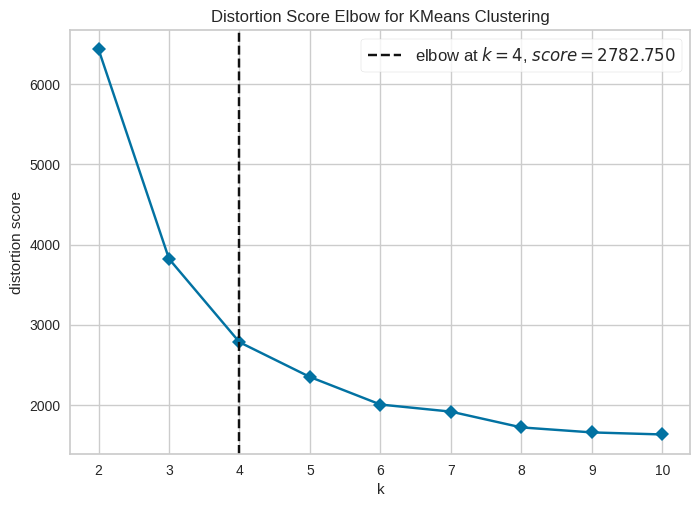

In [68]:
plot_model(mdl_kmeans_all_no_year, plot = 'elbow')

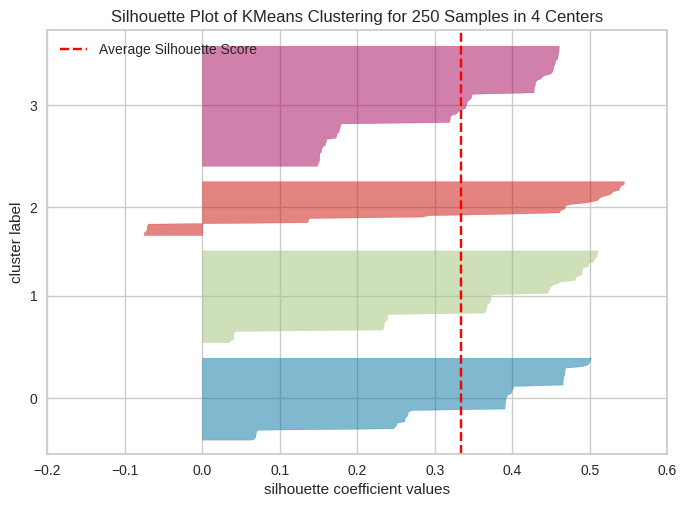

In [69]:
plot_model(mdl_kmeans_all_no_year, plot = 'silhouette')

In [70]:
plot_model(mdl_kmeans_all_no_year, plot = 'distribution')

In [71]:
plot_model(mdl_kmeans_all_no_year, plot = 'cluster')

In [72]:
plot_model(mdl_kmeans_all_no_year, plot = 'tsne')

In [73]:
evaluate_model(mdl_kmeans_all_no_year)

## Filmes por cluster

In [74]:
df_processed['cluster'] = df_kmeans_all_no_year['Cluster']
df_processed

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    cluster  
0            29  viver terra barbie perfeito lugar perfeito. me...  Cluster 0  
1            21  dois homens presos reúnem longo vários anos, e...  Cluster 3  
2            20  patriarca idoso dinastia crime organizado tran...  Cluster 3  
3            33  ameaça conhecida coringa surge passado, causa ...  Cluster 2  
4            41  1950, michael corleone, agora frente família, ...  Cluster 2  
..          ...                                                ...        ...  
245          32  aspirante escritora durante movimento direitos...  Cluster 2  
246          17  enfermeira encarregada atriz silenciosa descob...  Cluster 1  
247          20  nascido natal original estábulo lado jesus, br...  Cluster 3  
248          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 3  
249          22  esposa amante diretor escola detestável planej...  Cluster 3  

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [75]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

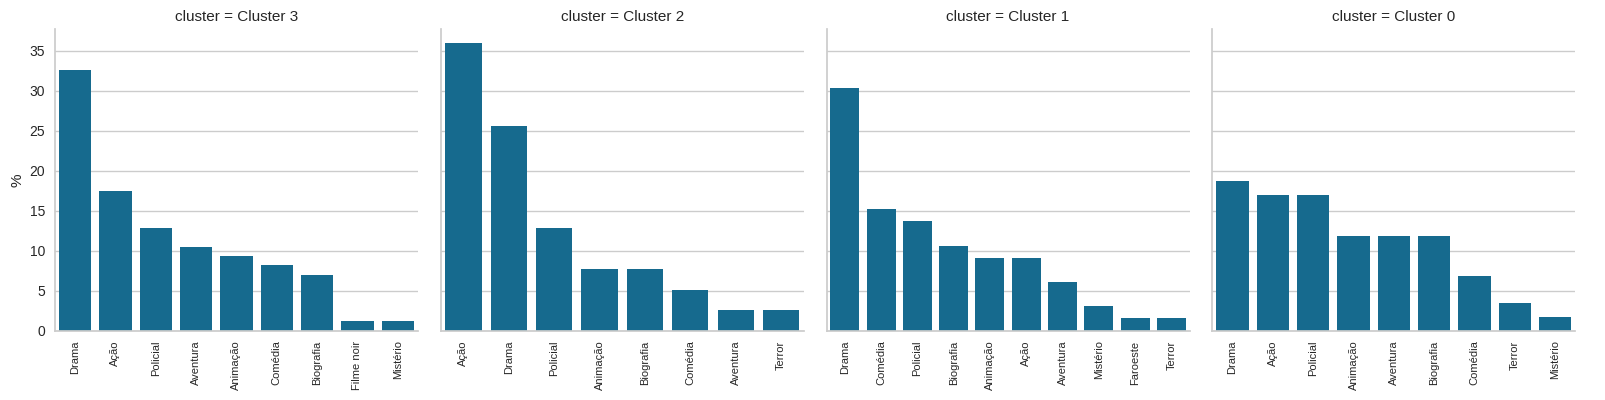

In [76]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

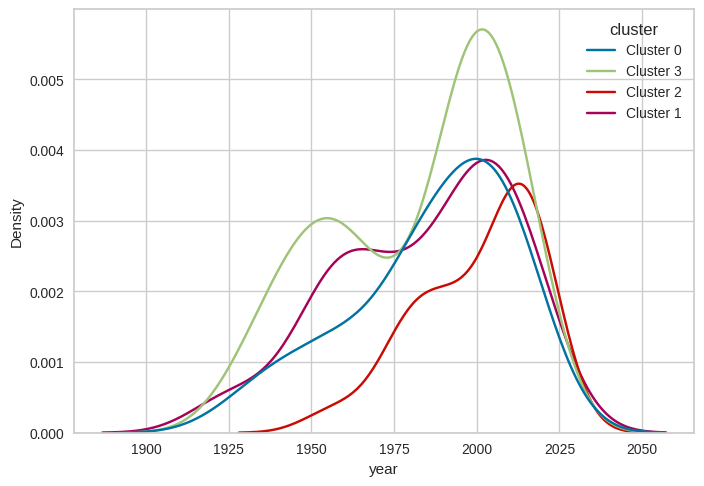

In [77]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [78]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação  11.864407   9.090909   7.692308   9.302326
1          Aventura  11.864407   6.060606   2.564103  10.465116
2              Ação  16.949153   9.090909  35.897436  17.441860
3         Biografia  11.864407  10.606061   7.692308   6.976744
4           Comédia   6.779661  15.151515   5.128205   8.139535
5             Drama  18.644068  30.303030  25.641026  32.558140
6          Faroeste   0.000000   1.515152   0.000000   0.000000
7        Filme noir   0.000000   0.000000   0.000000   1.162791
8          Mistério   1.694915   3.030303   0.000000   1.162791
9          Policial  16.949153  13.636364  12.820513  12.790698
10           Terror   3.389831   1.515152   2.564103   0.000000

In [79]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0  11.864407
1   Aventura  Cluster 0  11.864407
2       Ação  Cluster 0  16.949153
3  Biografia  Cluster 0  11.864407
4    Comédia  Cluster 0   6.779661

In [80]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 0


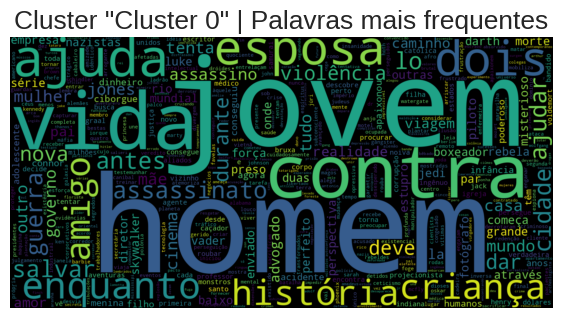

Cluster 3


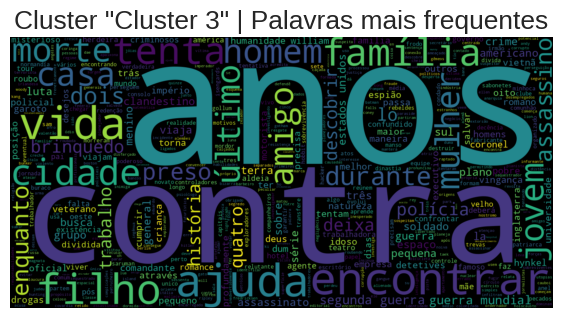

Cluster 2


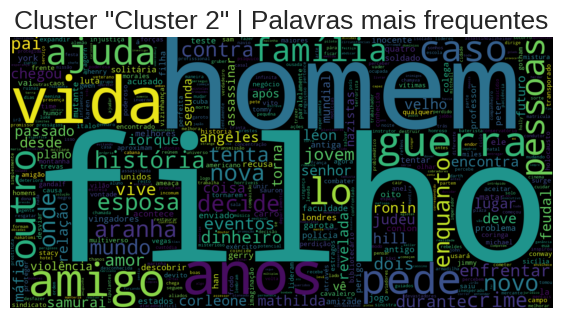

Cluster 1


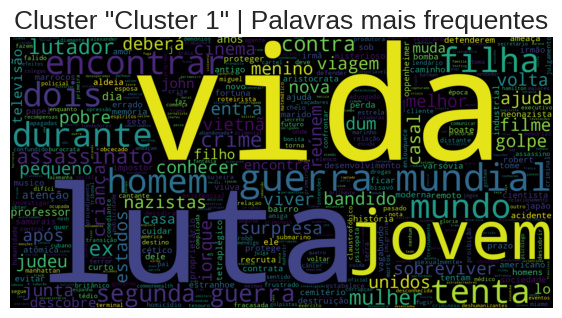

In [81]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 3

In [82]:
#Escreva aqui as suas análises / conclusões

CHECKPOINT 2:

In [83]:
!pip install pycaret --upgrade

In [84]:
from pycaret.clustering import setup, compare_models, create_model, assign_model, plot_model, predict_model

print("Importação bem-sucedida!")

ImportError: cannot import name 'compare_models' from 'pycaret.clustering' (/usr/local/lib/python3.10/dist-packages/pycaret/clustering/__init__.py)

In [86]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregando os dados
df = pd.read_csv('/content/all_movies.csv', sep=';')

# Exibindo as colunas disponíveis
print("Colunas disponíveis no DataFrame:")
print(df.columns)

# Verificando se 'title' está presente, caso contrário, usando a primeira coluna como identificador
title_column = 'title' if 'title' in df.columns else df.columns[0]

# Preparação dos dados
df['sinopse'] = df['sinopse'].fillna('')

# Vetorização TF-IDF da sinopse
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['sinopse'])

# Combinando features numéricas com TF-IDF
X = np.hstack((df[['year']].values, tfidf_matrix.toarray()))

# Normalização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nPrimeiras 10 linhas com {title_column} e cluster:")
print(df[[title_column, 'cluster']].head(10))

# Função para recomendar filmes
def recommend_movies(chosen_synopsis, n_recommendations=5):
    # Vetorizar a sinopse escolhida
    chosen_tfidf = tfidf.transform([chosen_synopsis])

    # Preparar os dados para prever o cluster
    chosen_features = np.hstack(([df['year'].mean()], chosen_tfidf.toarray()[0]))
    chosen_scaled = scaler.transform([chosen_features])

    # Prever o cluster
    predicted_cluster = kmeans.predict(chosen_scaled)[0]

    # Filtrar filmes do mesmo cluster
    cluster_movies = df[df['cluster'] == predicted_cluster]

    # Selecionar recomendações aleatórias do cluster
    recommendations = cluster_movies.sample(n_recommendations)

    return recommendations[[title_column, 'sinopse']]

# Exemplo de uso
sample_synopses = df['sinopse'].sample(5).tolist()
for i, synopsis in enumerate(sample_synopses, 1):
    print(f"\nSinopse {i}:")
    print(synopsis[:200] + "...")  # Mostrando apenas os primeiros 200 caracteres

chosen_index = int(input("\nEscolha uma sinopse (1-5): ")) - 1
chosen_synopsis = sample_synopses[chosen_index]

recommendations = recommend_movies(chosen_synopsis)
print("\nFilmes recomendados:")
for _, movie in recommendations.iterrows():
    print(f"{title_column}: {movie[title_column]}")
    print(f"Sinopse: {movie['sinopse'][:200]}...")
    print()

Colunas disponíveis no DataFrame:
Index(['title_pt', 'title_en', 'year', 'rating', 'genre', 'sinopse'], dtype='object')

Primeiras 10 linhas com title_pt e cluster:
                                  title_pt  cluster
0                                   Barbie        4
1                    Um Sonho de Liberdade        4
2                        O Poderoso Chefão        4
3           Batman: O Cavaleiro das Trevas        4
4                     O Poderoso Chefão II        4
5                 12 Homens e uma Sentença        4
6                     A Lista de Schindler        4
7     O Senhor dos Anéis: O Retorno do Rei        4
8        Pulp Fiction - Tempo de Violência        4
9  O Senhor dos Anéis: A Sociedade do Anel        4

Sinopse 1:
Dois caçadores de recompensas com as mesmas intenções se reúnem para encontrar um criminoso ocidental....

Sinopse 2:
Um irlandês conquista o coração de uma viúva rica e assume a posição aristocrática de seu falecido marido na Inglaterra do século XVI

In [89]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [91]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configuração da página
st.set_page_config(page_title="Sistema de Recomendação de Filmes", layout="wide")

@st.cache_data
def load_data():
    df = pd.read_csv('/content/all_movies.csv', sep=';')
    return df

@st.cache_resource
def create_models(df):
    # Preparação dos dados
    df['sinopse'] = df['sinopse'].fillna('')

    # Vetorização TF-IDF da sinopse
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['sinopse'])

    # Modelo 1: Usando ano e sinopse
    X_full = np.hstack((df[['year']].values, tfidf_matrix.toarray()))
    scaler_full = StandardScaler()
    X_full_scaled = scaler_full.fit_transform(X_full)
    kmeans_full = KMeans(n_clusters=5, random_state=42)
    kmeans_full.fit(X_full_scaled)

    # Modelo 2: Usando apenas sinopses vetorizadas
    kmeans_synopses = KMeans(n_clusters=5, random_state=42)
    kmeans_synopses.fit(tfidf_matrix)

    return tfidf, kmeans_full, scaler_full, kmeans_synopses

# Carregando dados e criando modelos
df = load_data()
tfidf, kmeans_full, scaler_full, kmeans_synopses = create_models(df)

# Funções de recomendação
def recommend_movies_method1(chosen_synopsis, n_recommendations=5):
    chosen_tfidf = tfidf.transform([chosen_synopsis])
    chosen_features = np.hstack(([df['year'].mean()], chosen_tfidf.toarray()[0]))
    chosen_scaled = scaler_full.transform([chosen_features])
    predicted_cluster = kmeans_full.predict(chosen_scaled)[0]
    cluster_movies = df[df['cluster'] == predicted_cluster]
    recommendations = cluster_movies.sample(n_recommendations)
    return recommendations[['title_pt', 'sinopse']]

def recommend_movies_method2(user_synopsis, n_recommendations=5):
    user_tfidf = tfidf.transform([user_synopsis])
    predicted_cluster = kmeans_synopses.predict(user_tfidf)[0]
    cluster_movies = df[df['cluster'] == predicted_cluster]
    recommendations = cluster_movies.sample(n_recommendations)
    return recommendations[['title_pt', 'sinopse']]

# Interface do usuário
st.title('Sistema de Recomendação de Filmes')

method = st.radio("Escolha o método de recomendação:",
                  ('Escolher entre sinopses existentes', 'Escrever sua própria sinopse'))

if method == 'Escolher entre sinopses existentes':
    st.subheader("Sinopses Disponíveis")
    sample_synopses = df['sinopse'].sample(5).tolist()
    chosen_synopsis = st.selectbox("Escolha uma sinopse:",
                                   options=sample_synopses,
                                   format_func=lambda x: x[:200] + "..." if len(x) > 200 else x)

    if st.button('Recomendar Filmes'):
        with st.spinner('Buscando recomendações...'):
            recommendations = recommend_movies_method1(chosen_synopsis)

        st.subheader("Filmes Recomendados:")
        for _, movie in recommendations.iterrows():
            st.markdown(f"**{movie['title_pt']}**")
            st.write(movie['sinopse'][:200] + "...")
            st.markdown("---")

else:
    st.subheader("Escreva Sua Própria Sinopse")
    user_synopsis = st.text_area("Digite uma breve descrição do tipo de filme que você gostaria de assistir:")

    if st.button('Recomendar Filmes'):
        if user_synopsis:
            with st.spinner('Analisando sua sinopse e buscando recomendações...'):
                recommendations = recommend_movies_method2(user_synopsis)

            st.subheader("Filmes Recomendados:")
            for _, movie in recommendations.iterrows():
                st.markdown(f"**{movie['title_pt']}**")
                st.write(movie['sinopse'][:200] + "...")
                st.markdown("---")
        else:
            st.warning("Por favor, escreva uma sinopse antes de pedir recomendações.")

# Adicionar informações sobre o dataset
st.sidebar.title("Informações do Dataset")
st.sidebar.write(f"Total de filmes: {len(df)}")
st.sidebar.write(f"Período: {df['year'].min()} - {df['year'].max()}")

# Mostrar os gêneros mais comuns
genres = df['genre'].str.split(',').explode().str.strip().value_counts()
st.sidebar.write("Gêneros mais comuns:")
st.sidebar.bar_chart(genres.head(10))

2024-09-23 01:36:54.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.596 No runtime found, using MemoryCacheStorageManager
2024-09-23 01:36:54.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.642 No runtime found, using MemoryCacheStorageManager
2024-09-23 01:36:54.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-23 01:36:54.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

In [87]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregando os dados
df = pd.read_csv('/content/all_movies.csv', sep=';')

# Verificando as colunas disponíveis
print("Colunas disponíveis no DataFrame:")
print(df.columns)

# Usando 'title_pt' como identificador do filme, se disponível
title_column = 'title_pt' if 'title_pt' in df.columns else df.columns[0]

# Preparação dos dados
df['sinopse'] = df['sinopse'].fillna('')

# Vetorização TF-IDF da sinopse
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['sinopse'])

# Modelo 1: Usando ano e sinopse
X_full = np.hstack((df[['year']].values, tfidf_matrix.toarray()))
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)
kmeans_full = KMeans(n_clusters=5, random_state=42)
df['cluster_full'] = kmeans_full.fit_predict(X_full_scaled)

# Modelo 2: Usando apenas sinopses vetorizadas
kmeans_synopses = KMeans(n_clusters=5, random_state=42)
df['cluster_synopses'] = kmeans_synopses.fit_predict(tfidf_matrix)

# Função para recomendar filmes (Método 1)
def recommend_movies_method1(chosen_synopsis, n_recommendations=5):
    chosen_tfidf = tfidf.transform([chosen_synopsis])
    chosen_features = np.hstack(([df['year'].mean()], chosen_tfidf.toarray()[0]))
    chosen_scaled = scaler_full.transform([chosen_features])
    predicted_cluster = kmeans_full.predict(chosen_scaled)[0]
    cluster_movies = df[df['cluster_full'] == predicted_cluster]
    recommendations = cluster_movies.sample(n_recommendations)
    return recommendations[[title_column, 'sinopse']]

# Função para recomendar filmes (Método 2)
def recommend_movies_method2(user_synopsis, n_recommendations=5):
    user_tfidf = tfidf.transform([user_synopsis])
    predicted_cluster = kmeans_synopses.predict(user_tfidf)[0]
    cluster_movies = df[df['cluster_synopses'] == predicted_cluster]
    recommendations = cluster_movies.sample(n_recommendations)
    return recommendations[[title_column, 'sinopse']]

# Interface do usuário
print("\nSistema de Recomendação de Filmes")
method = input("Escolha o método (1 ou 2):\n1. Escolher entre sinopses existentes\n2. Escrever sua própria sinopse\nSua escolha: ")

if method == '1':
    sample_synopses = df['sinopse'].sample(5).tolist()
    for i, synopsis in enumerate(sample_synopses, 1):
        print(f"\nSinopse {i}:")
        print(synopsis[:200] + "...")

    chosen_index = int(input("\nEscolha uma sinopse (1-5): ")) - 1
    chosen_synopsis = sample_synopses[chosen_index]
    recommendations = recommend_movies_method1(chosen_synopsis)
else:
    user_synopsis = input("\nEscreva uma sinopse de filme que você gostaria de assistir: ")
    recommendations = recommend_movies_method2(user_synopsis)

print("\nFilmes recomendados:")
for _, movie in recommendations.iterrows():
    print(f"{title_column}: {movie[title_column]}")
    print(f"Sinopse: {movie['sinopse'][:200]}...")
    print()

Colunas disponíveis no DataFrame:
Index(['title_pt', 'title_en', 'year', 'rating', 'genre', 'sinopse'], dtype='object')

Sistema de Recomendação de Filmes
Escolha o método (1 ou 2):
1. Escolher entre sinopses existentes
2. Escrever sua própria sinopse
Sua escolha: 1

Sinopse 1:
Depois de despertar de um coma de quatro anos, uma antiga assassina busca vingança contra o grupo de assassinos que a traiu....

Sinopse 2:
Depois de descobrir que tem câncer terminal, um burocrata tenta encontrar um sentido para sua vida....

Sinopse 3:
Um comediante falido enlouquece e se torna um assassino psicopata....

Sinopse 4:
O padre Harihar Ray, sonhando com uma vida melhor para si e sua família, deixa sua aldeia rural de Bengala em busca de trabalho....

Sinopse 5:
Uma ingênua se insinua na vida de uma atriz de teatro, e de seu círculo de amigas de teatro....

Escolha uma sinopse (1-5): 1

Filmes recomendados:
title_pt: Klaus
Sinopse: Um simples ato de bondade sempre provoca outro, mesmo em um lugar g